In [1]:
import pandas as pd 
import numpy as np 
import datetime 
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import svm, grid_search, datasets

In [2]:
business = pd.read_csv('business.csv')

/Users/srai/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
business.shape

(85901, 98)

In [4]:
business.columns

Index(['attributes.Ambience.divey', 'attributes.Dietary Restrictions.vegan',
       'attributes.Happy Hour', 'hours.Thursday.open',
       'attributes.Order at Counter',
       'attributes.Hair Types Specialized In.africanamerican',
       'attributes.Hair Types Specialized In.kids', 'attributes.BYOB',
       'hours.Friday.open', 'attributes.Good For.latenight',
       'attributes.Outdoor Seating', 'attributes.Alcohol',
       'attributes.Ambience.classy', 'attributes.By Appointment Only',
       'attributes.Parking.lot', 'business_id', 'attributes.Ambience.touristy',
       'attributes.Corkage', 'hours.Tuesday.open',
       'attributes.Good For.brunch', 'categories', 'attributes.Waiter Service',
       'hours.Monday.open', 'name', 'attributes.Parking.street',
       'attributes.Ambience.hipster', 'attributes.BYOB/Corkage',
       'attributes.Hair Types Specialized In.straightperms',
       'attributes.Music.live', 'attributes.Dietary Restrictions.dairy-free',
       'attributes.Music.

In [5]:
business.head()

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,attributes.Noise Level,attributes.Smoking,attributes.Attire,attributes.Hair Types Specialized In.curly,attributes.Good For Groups,neighborhoods,attributes.Open 24 Hours,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale
0,False,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,False,...,average,NaN,casual,NaN,True,[],NaN,False,NaN,False
1,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,True,[],NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,True,NaN,False,10:00,NaN,NaN,NaN,NaN,10:00,False,...,average,no,casual,NaN,True,[],NaN,False,NaN,False
4,NaN,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,NaN,...,NaN,NaN,NaN,NaN,True,[],NaN,NaN,NaN,NaN


#### To start with lets do some sanity checks on some of the attributes to confirm that there are sufficient dtaa points

In [6]:
business['latitude'].describe()

count    85901.000000
mean        37.034786
std          5.389208
min         32.865882
25%         33.506767
50%         35.314392
75%         36.203094
max         56.033777
Name: latitude, dtype: float64

In [7]:
business['longitude'].describe()

count    85901.000000
mean       -99.107318
std         27.437773
min       -115.386550
25%       -115.062628
50%       -111.943739
75%        -80.951101
max          8.549249
Name: longitude, dtype: float64

In [8]:
business['attributes.Good For Groups'].describe()

count     27794
unique        2
top        True
freq      24790
Name: attributes.Good For Groups, dtype: object

#### Sanity checks above reveal that some attributes like latitude, and longitude are available for all members of the data set, and other attributes such as 'attributes.Good For Groups' are available for almost a third of the dataset.  We are not including the sanity checks for other attributes in this notebook. In our modeling exercise, it may be good to ignore some attributes which are very sparse such as 'attributes.Dietary Restrictions.vegan'. However in this notebook we have not yet implemented the ability to exclude some attributes based on certain criteria.

## Lets take a simple problem 
#### Can we predict the star rating of a business based on some very simple business attributes such as location . The motivation behind this is that, often we will find examples where a business has not been rated by users, (for example new business). In cases like this it will be useful if we can predict a star rating based on some basic atributes of the business.

In [9]:
X = business
y = business['stars']
X_train_index,X_test_index,y_train,y_test = train_test_split(X.index,y,test_size=0.2, random_state = 1)

In [10]:
numeric_columns = ['latitude', 'longitude']

In [11]:
X_train = X.iloc[X_train_index].as_matrix(numeric_columns)
X_test = X.iloc[X_test_index].as_matrix(numeric_columns)

In [12]:
import sklearn.linear_model
lr = sklearn.linear_model.LinearRegression()
model_lr = lr.fit(X_train, y_train)

In [13]:
model_lr.score(X_train, y_train)

0.00033301485390291319

In [14]:
model_lr.score(X_test, y_test)

0.00022648665467461804

#### Above scores suggest that Linear Regression model does not fit the data well, in fact it underfits. The training score is low, and the testing score is also low

#### Lets now add some non-numeric features to the model and see if the score improves. For doing this we need to identify non-numeric features which we beleive based on understanding of the problem will improve the prediction. As an example lets add all attributes of the business which provide information about the ambience, and also its price range. These attributes together with location might be good predictors for the star rating

In [15]:
non_numeric_columns_ambience = [k for k in business.columns if 'Ambience' in k]
feature_columns = ['latitude', 'longitude','attributes.Price Range']
feature_columns.extend(non_numeric_columns_ambience)
X = business
y = business['stars']
X_train_index,X_test_index,y_train,y_test = train_test_split(X.index,y,test_size=0.2, random_state = 1)
X_train = X.iloc[X_train_index].fillna(-1).as_matrix(feature_columns)
X_test = X.iloc[X_test_index].fillna(-1).as_matrix(feature_columns)
lr = sklearn.linear_model.LinearRegression()
model_lr = lr.fit(X_train, y_train)
print("Train Score = ", model_lr.score(X_train, y_train))
print("Test Score = ", model_lr.score(X_test, y_test))

Train Score =  0.0141083917798
Test Score =  0.0139446515319


####  Above attributes improve our R2 score very slightly for predicting the review count of a business based on its meta data attributes. Lets formalize this approach a bit, so that we can apply this more easily to other examples, and continue our search for better models to improve our scores

In [16]:
def get_columns_from_prefix(biz_df, prefix):
    return [col for col in biz_df.columns if prefix in col]
def eval_score(model, model_name, biz_df, numeric_col, other_col_prefix, y_col_name):
    X = biz_df
    y = biz_df[y_col_name]
    feature_columns = copy.copy(numeric_col)
    for col_prefix in other_col_prefix:
        feature_columns.extend(get_columns_from_prefix(biz_df, col_prefix))
    X_train_index,X_test_index,y_train,y_test = train_test_split(X.index,y,test_size=0.2, random_state = 1)    
    X_train = X.iloc[X_train_index].fillna(0).as_matrix(feature_columns)
    X_test = X.iloc[X_test_index].fillna(0).as_matrix(feature_columns)
    model = model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print('Model Name : {0}, Train Score = {1}, Test Score = {2}, Train Set size = {3}'.format(model_name, train_score,test_score,X_train.shape))
    return {
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test,
        'model':model,
        'train_score':train_score,
        'test_score':test_score}

#### Lets run the same example from before with above functions to confirm results produced are identical

In [17]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience']
y_col_name = 'stars'
model = sklearn.linear_model.LinearRegression()
eval_res = eval_score(model, 'LinearRegression', business, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LinearRegression, Train Score = 0.006101224860929788, Test Score = 0.006819635864603879, Train Set size = (68720, 12)


#### Evaluation results are identical to previous run. Now lets add more features, and evaluate if it improves the model scores

In [18]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair']
y_col_name = 'stars'
model = sklearn.linear_model.LinearRegression()
eval_res = eval_score(model,'LinearRegression', business, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LinearRegression, Train Score = 0.03681422607497675, Test Score = 0.037212404973611224, Train Set size = (68720, 46)


#### Addition of more features improved the R2 score on test data slightly. Notice that we have not yet considered the category information while computing these models. Lets try adding the category infomration as well. 

#### Lets add all information available from categores as boolean variables. For example if a business has 'Mexican' as a category, we will add a columns to our data frame that will be True when 'Mexican' is a category present in the 'categories' column for that business. To compute this we will need to know the set of all categories first 

In [19]:
def add_categories(business):
    all_categories = pd.unique([item for sublist in business['categories'].apply(eval) for item in sublist])
    for cat in all_categories:
        business['computed.category.' + str(cat)] = business['categories'].apply(lambda x: True if cat in x else False)
    return business
business = add_categories(business)

#### Lets compute new models now that use these additional columns 

In [20]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.']
y_col_name = 'stars'
lr = LinearRegression()
eval_res = eval_score(lr,'LinearRegression', business, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LinearRegression, Train Score = 0.25138468773889755, Test Score = 0.22334746185294585, Train Set size = (68720, 1078)


#### The train score is  slightly greater than the test score,indicating overfitting in this linear regression model. Lets see if building a model that can capture the non-linearity and interactiion effects amongst the features. RandomForest and GradientBoosting approaches are both capable of acheiving this. We expect both the train and test scores to imrove as a result of using these models.   These models  takes a few minutes to generate

In [21]:
rf = RandomForestRegressor(n_estimators=50, max_depth = 6, verbose = 1,n_jobs = 4)
eval_res = eval_score(rf,'Random Forest', business, numeric_col_names, other_col_prefix, y_col_name)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   32.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Model Name : Random Forest, Train Score = 0.10923561524009928, Test Score = 0.09753894643746186, Train Set size = (68720, 1078)


#### The random forest model above has low score on both train data as well as test data. This suggests that the random forest as defined above is not able to fit the data in a manner comparable with Linear Regression. Lets us perform a grid serach using Cross Validation for best parameters. Please note this takes a few minutes to run. 

In [22]:
parameters = {'n_estimators':[50, 100], 'max_depth':[6, 12], 'verbose':[1],'n_jobs':[4]}
rf = RandomForestRegressor()
clf = grid_search.GridSearchCV(rf, parameters)
eval_res = eval_score(clf,'Random Forest', business, numeric_col_names, other_col_prefix, y_col_name)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: 

Model Name : Random Forest, Train Score = 0.2126454261829409, Test Score = 0.16968005758541294, Train Set size = (68720, 1078)


#### The grid search based on Cross Validation above has yeilded the best results so far. Let us now explore if any other modeling techniques can help improve our sciore further. 

#### Lets explore now if gradient boosting regression, another advanced regression technique can improve the fit by improving the score on our training, as well as test set 

In [23]:
gbr = GradientBoostingRegressor(max_depth = 10,  verbose=10)
eval_res = eval_score(gbr, 'Gradient Boosting',business, numeric_col_names, other_col_prefix, y_col_name)

      Iter       Train Loss   Remaining Time 
         1           0.8674           10.69m
         2           0.8455           10.61m
         3           0.8274           10.52m
         4           0.8098           10.53m
         5           0.7953           10.51m
         6           0.7836           10.38m
         7           0.7720           10.01m
         8           0.7618            9.72m
         9           0.7525            9.71m
        10           0.7443            9.70m
        11           0.7374            9.63m
        12           0.7307            9.67m
        13           0.7211            9.85m
        14           0.7149            9.58m
        15           0.7093            9.32m
        16           0.7056            8.97m
        17           0.7000            8.90m
        18           0.6953            8.69m
        19           0.6918            8.39m
        20           0.6875            8.31m
        21           0.6831            8.07m
        2

#### Above Gradient Boosting model improves both the training score as well as test score in comparision with the LinearRegression model. However there is a significant gap between the train and test scores. This indicates overfitting. We should therefore explore approaches that reduce the variance. One way to achieve this with Gradient Boosting and other ensamble methods is by reducing the tree depth,  and increasing the number of estimators. We evaluate one such aproach towards the end of this notebook, since it takes longer to run.

#### The best model for improving the scores on test data set so far, is the gradient boosted model with  individual trees in the ensamble grown to a depth of 10

#### Lets try to bring in features into the model that also include user behavior to complement the business meta data 
#### Does the prediction of a business star rating improve if we know the number of checkins to the business on different days?

#### Lets get the check in data 

In [24]:
checkin = pd.read_csv('checkin.csv')

In [25]:
checkin.head()

,checkin_info.9-0,checkin_info.9-1,checkin_info.9-2,checkin_info.9-3,checkin_info.9-4,checkin_info.9-5,checkin_info.9-6,checkin_info.20-2,checkin_info.20-3,checkin_info.20-0,...,checkin_info.6-1,checkin_info.6-0,checkin_info.3-1,checkin_info.18-6,checkin_info.18-5,checkin_info.18-4,checkin_info.18-3,checkin_info.18-2,checkin_info.18-1,checkin_info.18-0
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



#### Lets see if the prediction scores for star rating of a business can be improved if we also include the check in info as one of the predictors. Note that this attribute is a user interaction based attribute, and deviates slightly from our use case that a business was new. However this score  

In [26]:
business_checkin = business.merge(checkin, on = 'business_id', how = 'left')

In [27]:
business_checkin.head()

,attributes.Ambience.divey,attributes.Dietary Restrictions.vegan,attributes.Happy Hour,hours.Thursday.open,attributes.Order at Counter,attributes.Hair Types Specialized In.africanamerican,attributes.Hair Types Specialized In.kids,attributes.BYOB,hours.Friday.open,attributes.Good For.latenight,...,checkin_info.6-1,checkin_info.6-0,checkin_info.3-1,checkin_info.18-6,checkin_info.18-5,checkin_info.18-4,checkin_info.18-3,checkin_info.18-2,checkin_info.18-1,checkin_info.18-0
0,False,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,True,NaN,False,10:00,NaN,NaN,NaN,NaN,10:00,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,11:00,NaN,NaN,NaN,NaN,11:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Lets add all the 'checkin_info' from the business_checkin data frame as features into the above model

In [28]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.', 'checkin_info']
y_col_name = 'stars'
lr = LinearRegression()
eval_res = eval_score(lr, 'LinearRegression', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LinearRegression, Train Score = 0.25444365497076404, Test Score = 0.22425768482976072, Train Set size = (68720, 1246)


#### We will try a gradient boosting approach on this towards the end of the notebook

#### Now lets change our problem definition slightly, to see if this problem can be solved as a classification problem. 
#### Lets try to predict now whether a business has a 'Good Score' or 'Bad Score' based on its meta data and check in info or not 
#### We define a 'Good Score' for business to be any rating >= average (computed over the training set)

In [29]:
mean_star_rating = eval_res['y_train'].mean()

In [30]:
mean_star_rating

3.696711292200233

In [31]:
business_checkin['good_score'] = business_checkin['stars'].apply(lambda x: x >= mean_star_rating)

#### Lets train a logistic regression model on this, and create a classification model using only business meta data as its features (i.e not including checkin info)

In [32]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.']
y_col_name = 'good_score'
lr = LogisticRegression()
eval_res = eval_score(lr, 'LogisticRegression', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LogisticRegression, Train Score = 0.6922147846332946, Test Score = 0.6807519934811711, Train Set size = (68720, 1078)


#### The scores above are high, but can be mis-leading, lets compute the precision recall curves 

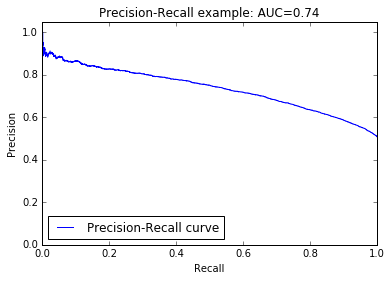

In [33]:
%matplotlib inline 
def plot_precision_recall(model, X_test, y_test):
    y_score = model.decision_function(X_test)
    precision, recall, threshold = precision_recall_curve(y_test,y_score)
    average_precision = average_precision_score(y_test, y_score)
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()
    return pd.DataFrame({'precision':precision[1:], 'recall':recall[1:], 'threshold':threshold})
precision_recall_threshold = plot_precision_recall(lr, eval_res['X_test'], eval_res['y_test'])

#### An AUC of 0.69 as above, indicates that the model fits the data reasonably well, by choosing appropriate threshold for predicton we can achieve the desired precision, as well as recall

#### Any of the threshold values from above table will yeild a precision and recall > 0.68

In [34]:
precision_recall_threshold.query ('precision > 0.68 and recall > 0.68').head()

,precision,recall,threshold
8199,0.680004,0.699095,-0.039632
8200,0.680080,0.699095,-0.039563
8201,0.680156,0.699095,-0.039458
8202,0.680120,0.698980,-0.038996
8203,0.680196,0.698980,-0.038929


#### Lets include checkin infomration in this model, and evaluate again

In [35]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.','checkin_info']
y_col_name = 'good_score'
lr = LogisticRegression()
eval_res = eval_score(lr, 'LogisticRegression', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LogisticRegression, Train Score = 0.6522991850989522, Test Score = 0.6476922181479542, Train Set size = (68720, 1246)


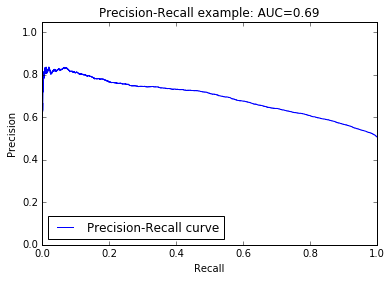

In [36]:
precision_recall_threshold = plot_precision_recall(lr, eval_res['X_test'], eval_res['y_test'])

In [37]:
gbr = GradientBoostingClassifier(n_estimators=100, max_depth = 8,  verbose=10)
eval_res = eval_score(gbr, 'Gradient Boosting Classifier', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

      Iter       Train Loss   Remaining Time 
         1           1.3638           13.66m
         2           1.3462           13.42m
         3           1.3297           13.96m
         4           1.3156           14.18m
         5           1.3036           14.24m
         6           1.2913           14.15m
         7           1.2802           14.00m
         8           1.2706           14.17m
         9           1.2616           14.22m
        10           1.2533           14.19m
        11           1.2457           14.19m
        12           1.2395           13.89m
        13           1.2329           13.73m
        14           1.2267           13.62m
        15           1.2220           13.31m
        16           1.2154           13.18m
        17           1.2111           13.04m
        18           1.2080           12.59m
        19           1.2042           12.43m
        20           1.1998           12.28m
        21           1.1966           11.99m
        2

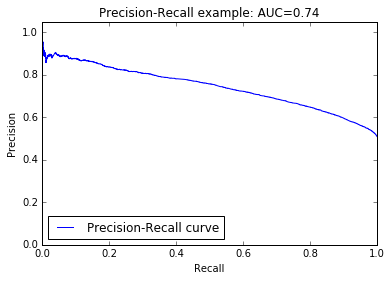

In [38]:
precision_recall_threshold = plot_precision_recall(gbr, eval_res['X_test'], eval_res['y_test'])

In [39]:
precision_recall_threshold.query ('precision > 0.68 and recall > 0.68').head()

,precision,recall,threshold
6974,0.680022,0.717658,0.033852
6975,0.680096,0.717658,0.034092
6976,0.680061,0.717543,0.034271
6977,0.680135,0.717543,0.034506
6979,0.680070,0.717085,0.035023


#### Computing Gradient boosted model for regression with a depth of 300
#### This takes a long time to generate, hence computing this at the end

In [40]:
numeric_col_names = ['latitude', 'longitude','attributes.Price Range']
other_col_prefix = ['Ambience','Good For','Music', 'Parking', 'Dietary Restrictions', 'Hair', 'computed.category.', 'checkin_info']
y_col_name = 'stars'
gbr = GradientBoostingRegressor(n_estimators=300, max_depth = 8,  verbose=10)
eval_res = eval_score(gbr, 'Gradient Boosting', business_checkin, numeric_col_names, other_col_prefix, y_col_name)

Model Name : LinearRegression, Train Score = 0.25444365497076404, Test Score = 0.22425768482976072, Train Set size = (68720, 1246)
      Iter       Train Loss   Remaining Time 
         1           0.8725           60.66m
         2           0.8539           61.54m
         3           0.8385           55.39m
         4           0.8231           52.77m
         5           0.8096           51.40m
         6           0.7983           50.85m
         7           0.7885           49.57m
         8           0.7787           49.25m
         9           0.7707           49.34m
        10           0.7628           49.44m
        11           0.7567           48.51m
        12           0.7505           47.58m
        13           0.7452           46.79m
        14           0.7418           45.44m
        15           0.7362           45.37m
        16           0.7316           44.85m
        17           0.7272           44.26m
        18           0.7236           43.32m
        19   

#### So far the R2 score of 0.2561 is the best we have for predicting a business's star rating using its meta data, and check in info. 